# Predict Future Sales

kaggle link : https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns; sns.set()

### Data

In [2]:
daily_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

### Exploration

headers

In [3]:
daily_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [7]:
test.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


<b> Checking the submission goal

In [8]:
len(test)

214200

In [9]:
df = test.groupby(['shop_id','item_id'])[['ID']].count().reset_index()
len(df)

214200

In [10]:
len(test.shop_id.unique())

42

In [11]:
test.groupby(['shop_id'])[['item_id']].nunique().reset_index()

,shop_id,item_id
0,2,5100
1,3,5100
2,4,5100
3,5,5100
4,6,5100
5,7,5100
6,10,5100
7,12,5100
8,14,5100
9,15,5100


<b> * for each shop and item id, predict the next forward count (by month) 
    <br>
<b> * regression target
    <br>
<b> * next data point ???

### The train data

In [12]:
def merge_basic(train_data, test_data):
    train_merge = train_data.merge(items, on = 'item_id', how = 'left')\
        .merge(categories, on = 'item_category_id', how = 'left')\
        .merge(test_data, on = ['shop_id','item_id'], how = 'inner')\
        .drop(columns = ['item_category_id'])

    train_merge['SaleDate'] = pd.to_datetime(train_merge['date'], format = '%d.%m.%Y')
    
    return train_merge

In [13]:
train_merge = merge_basic(daily_train, test)

In [14]:
len(train_merge.shop_id.unique()), len(train_merge.item_id.unique())

(42, 4716)

In [15]:
len(test.shop_id.unique()), len(test.item_id.unique())

(42, 5100)

Exploration with incomplete data

In [16]:
train_merge.shape, daily_train.shape

((1224439, 10), (2935849, 6))

In [17]:
dftime = train_merge.groupby('SaleDate')[['item_id']].nunique().reset_index()

Text(0.5, 1.0, 'time inspection using distinct count items')

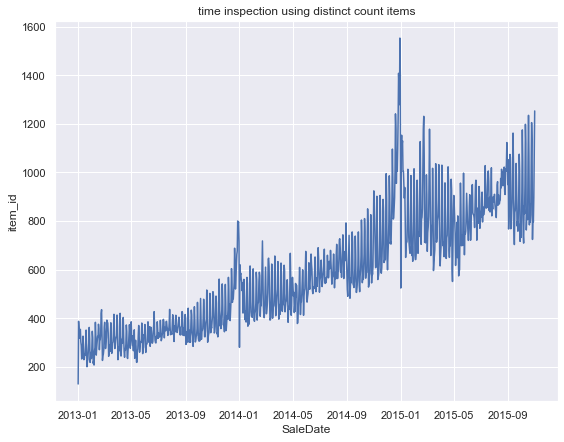

In [18]:
fig = plt.figure(figsize=(9,7))
sns.lineplot(data=dftime, x="SaleDate", y="item_id")
plt.title('time inspection using distinct count items')

#### basic data descriptive stats

In [19]:
def descriptor(variable):
    unique_values = len(train_merge[variable].unique())
    nans = len(train_merge[train_merge[variable].isna()])
    nones = len(train_merge[train_merge[variable] == None])
    print(f'the varaible {variable} has {unique_values} unique values, {nans} nans or {nones} nones')

In [20]:
for col in train_merge.columns :
    descriptor(col)

the varaible date has 1034 unique values, 0 nans or 0 nones
the varaible date_block_num has 34 unique values, 0 nans or 0 nones
the varaible shop_id has 42 unique values, 0 nans or 0 nones
the varaible item_id has 4716 unique values, 0 nans or 0 nones
the varaible item_price has 11941 unique values, 0 nans or 0 nones
the varaible item_cnt_day has 162 unique values, 0 nans or 0 nones
the varaible item_name has 4716 unique values, 0 nans or 0 nones
the varaible item_category_name has 60 unique values, 0 nans or 0 nones
the varaible ID has 111404 unique values, 0 nans or 0 nones
the varaible SaleDate has 1034 unique values, 0 nans or 0 nones


In [21]:
dftime = train_merge.groupby('date_block_num')[['item_id']].count().reset_index()

Text(0.5, 1.0, 'time inspection trqnsqction by month')

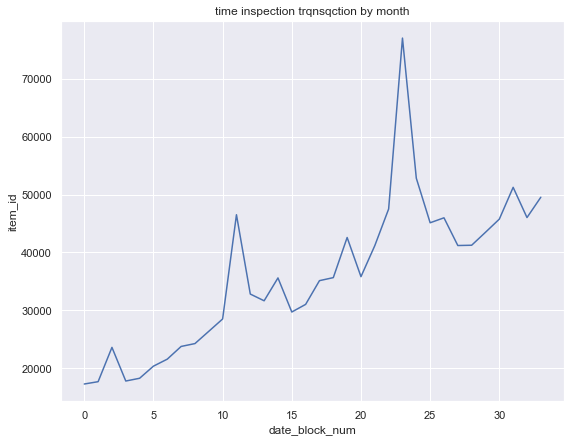

In [22]:
fig = plt.figure(figsize=(9,7))
sns.lineplot(data=dftime, x="date_block_num", y="item_id")
plt.title('time inspection trqnsqction by month')

In [23]:
dftime = train_merge.groupby(['shop_id','date_block_num'])[['item_id']].count()
dftime = dftime.groupby('shop_id').agg(mean = ('item_id','mean'),
                                       median = ('item_id','median'),
                                       min = ('item_id','min'),
                                       max = ('item_id','max'),
                                      )\
    .reset_index()

dftime = dftime.melt(id_vars=['shop_id'], value_vars=['mean','median','min','max'], var_name='metric', value_name='value')

Text(0.5, 1.0, 'shops distributions (month transactions aggregation)')

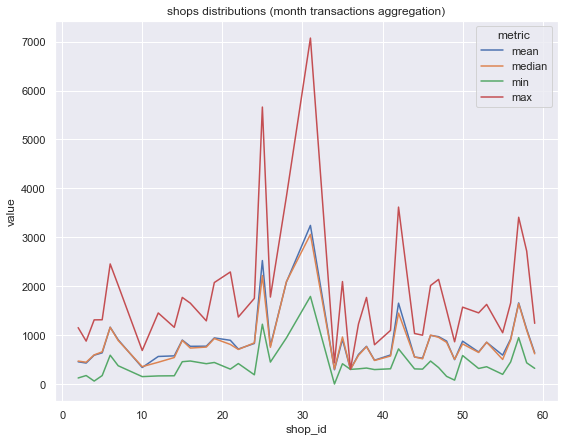

In [24]:
fig = plt.figure(figsize=(9,7))
sns.lineplot(data=dftime, x="shop_id", y="value", hue="metric")
plt.title('shops distributions (month transactions aggregation)')

In [25]:
dftime = train_merge.groupby(['item_id','date_block_num'])[['shop_id']].count()
dftime = dftime.groupby('item_id').agg(mean = ('shop_id','mean'),
                                       median = ('shop_id','median'),
                                       min = ('shop_id','min'),
                                       max = ('shop_id','max'),
                                      )\
    .reset_index()

dftime = dftime.melt(id_vars=['item_id'], value_vars=['mean','median','min','max'], var_name='metric', value_name='value')

Text(0.5, 1.0, 'item distributions (month transactions aggregation)')

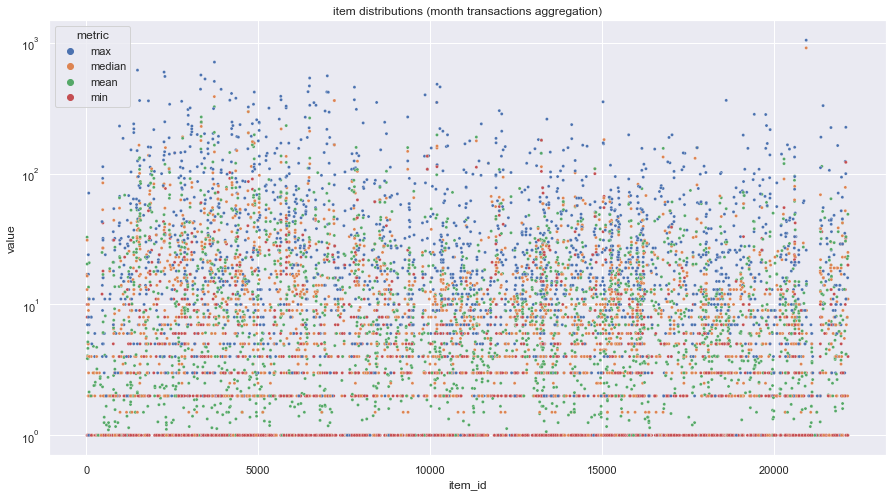

In [26]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(data=dftime.sample(frac=0.5), x="item_id", y="value", hue="metric", s=10)
plt.yscale('log')
plt.title('item distributions (month transactions aggregation)')

In [27]:
dftime = train_merge.groupby(['item_id','item_price'])[['shop_id']].count()
dftime = train_merge.groupby(['item_id']).agg(median = ('item_price','median'),
                                       min = ('item_price','min'),
                                       max = ('item_price','max'),).reset_index()

dftime = dftime.melt(id_vars=['item_id'], value_vars=['median','min','max'], var_name='metric', value_name='value')

Text(0.5, 1.0, 'distinct price per item distributions')

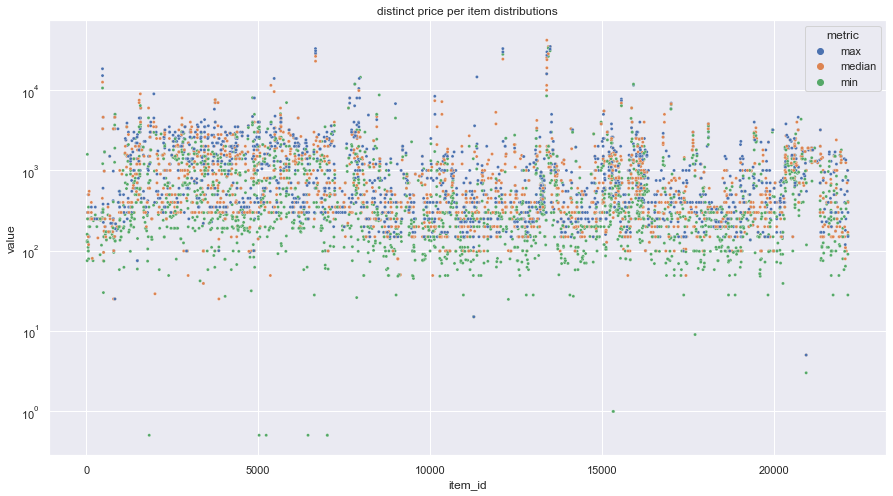

In [28]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(data=dftime.sample(frac=0.5), x="item_id", y="value", hue="metric", s = 10)
plt.yscale('log')
plt.title('distinct price per item distributions')

In [29]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
train_merge.item_cnt_day.describe()

count   1224439.0000
mean          1.3212
std           3.3130
min         -16.0000
25%           1.0000
50%           1.0000
75%           1.0000
max        2169.0000
Name: item_cnt_day, dtype: float64

In [30]:
dftime = train_merge.groupby(['item_id','item_cnt_day'])[['shop_id']].count()
dftime = train_merge.groupby(['item_id']).agg(median = ('item_cnt_day','median'),
                                       min = ('item_cnt_day','min'),
                                       max = ('item_cnt_day','max'),).reset_index()

dftime = dftime.melt(id_vars=['item_id'], value_vars=['median','min','max'], var_name='metric', value_name='value')

In [31]:
dftime.head()

,item_id,metric,value
0,30,median,1.0000
1,31,median,1.0000
2,32,median,1.0000
3,33,median,1.0000
4,38,median,1.0000


Text(0.5, 1.0, 'distinct volume sales per item distributions')

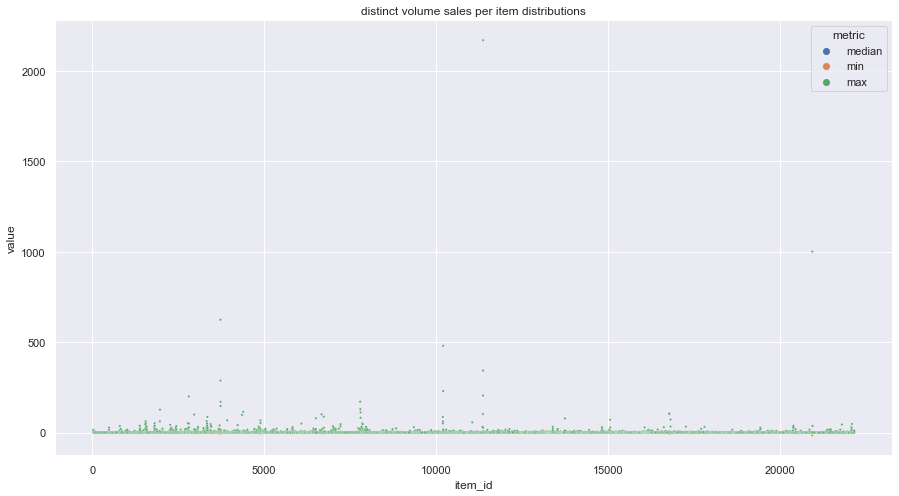

In [32]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(data=dftime, x="item_id", y="value", hue="metric", s = 5)
#plt.yscale('log')
plt.title('distinct volume sales per item distributions')

In [33]:
dfplot = train_merge.groupby(['item_cnt_day'])[['item_id']].count().reset_index().sort_values('item_cnt_day')

In [34]:
dfplot.item_id.describe()

count       162.0000
mean       7558.2654
std       84538.5561
min           1.0000
25%           1.0000
50%           4.0000
75%          32.5000
max     1072620.0000
Name: item_id, dtype: float64

Text(0.5, 1.0, 'serch of volume sales outliers')

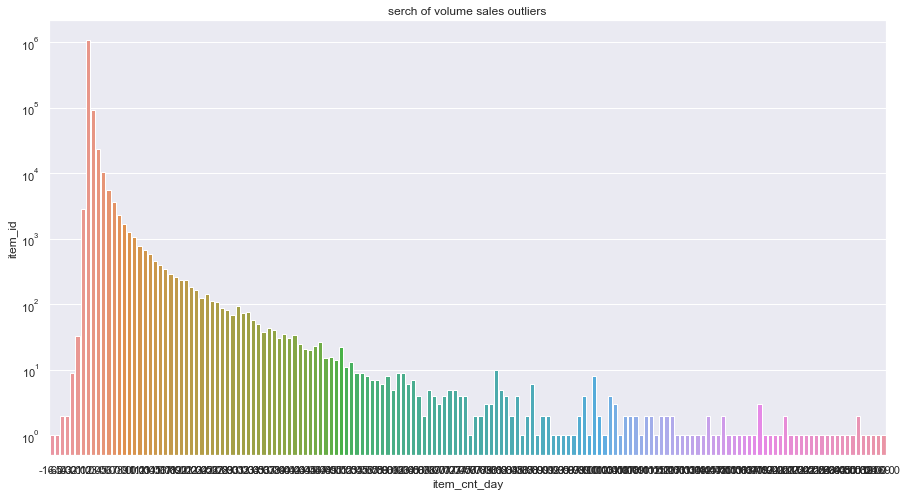

In [35]:
fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x="item_cnt_day", y="item_id", data=dfplot)
plt.yscale('log')
plt.title('serch of volume sales outliers')

In [36]:
train_merge.item_category_name.describe()

count                                 1224439
unique                                     60
top       Музыка - CD локального производства
freq                                   173049
Name: item_category_name, dtype: object

In [37]:
train_merge.groupby(['item_category_name'])[['item_id']].nunique().reset_index().sort_values('item_id',ascending = False).rename(columns = {'Item_id': 'transactions'})

,item_category_name,item_id
28,Кино - DVD,699
37,Музыка - CD локального производства,634
26,Кино - Blu-Ray,328
21,Игры PC - Цифра,252
40,Музыка - Винил,202
51,Подарки - Фигурки,163
14,Игры - XBOX 360,143
10,Игры - PS3,137
20,Игры PC - Стандартные издания,131
34,"Книги - Комиксы, манга",127


In [38]:
train_merge.SaleDate.min(), train_merge.SaleDate.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-10-31 00:00:00'))

#### some impresssions

* there is a clear trend and seasonality
* more items are salled in the present
* the target is a combination between shopId and ItemId
* its possible to find very high numbers of volume sales
* items negatives(are controled) (reverse logistics)
* the train data is incomplete for the test items
* predict 2015-11, predict all the items for all the shops, 0 sale is an option

### Furtner EDA

#### Outlier analysis

In [39]:
train_merge.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.0000,1.0000,ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,150983,2013-01-02
1,03.01.2013,0,25,2574,399.0000,2.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-03
2,05.01.2013,0,25,2574,399.0000,1.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-05
3,07.01.2013,0,25,2574,399.0000,1.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-07
4,08.01.2013,0,25,2574,399.0000,2.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-08


In [40]:
dfplot = train_merge.groupby(['item_cnt_day'])[['item_id']].count().reset_index().sort_values('item_cnt_day')
dfplot.item_id.describe()

count       162.0000
mean       7558.2654
std       84538.5561
min           1.0000
25%           1.0000
50%           4.0000
75%          32.5000
max     1072620.0000
Name: item_id, dtype: float64

<b> High sales exploration

In [41]:
lowsales = train_merge[train_merge.item_cnt_day <= np.quantile(dfplot.item_id, 0.75, axis=0)]
highsales = train_merge[train_merge.item_cnt_day > np.quantile(dfplot.item_id, 0.75, axis=0)]

In [42]:
lowsales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.0000,1.0000,ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,150983,2013-01-02
1,03.01.2013,0,25,2574,399.0000,2.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-03
2,05.01.2013,0,25,2574,399.0000,1.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-05
3,07.01.2013,0,25,2574,399.0000,1.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-07
4,08.01.2013,0,25,2574,399.0000,2.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-08


In [43]:
highsales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_name,ID,SaleDate
361,31.05.2013,4,25,2808,999.0000,56.0000,"Diablo III [PC, Jewel, русская версия]",Игры PC - Стандартные издания,57021,2013-05-31
380,04.07.2013,6,25,2808,999.0000,70.0000,"Diablo III [PC, Jewel, русская версия]",Игры PC - Стандартные издания,57021,2013-07-04
383,11.07.2013,6,25,2808,999.0000,33.0000,"Diablo III [PC, Jewel, русская версия]",Игры PC - Стандартные издания,57021,2013-07-11
388,29.08.2013,7,25,2808,999.0000,71.0000,"Diablo III [PC, Jewel, русская версия]",Игры PC - Стандартные издания,57021,2013-08-29
391,05.09.2013,8,25,2808,999.0000,133.0000,"Diablo III [PC, Jewel, русская версия]",Игры PC - Стандартные издания,57021,2013-09-05


In [44]:
lowsales_pivot = lowsales.pivot_table(index = 'shop_id', values = 'item_cnt_day', aggfunc = 'count').reset_index().sort_values('item_cnt_day')
highsales_pivot = highsales.pivot_table(index = 'shop_id', values = 'item_cnt_day', aggfunc = 'count').reset_index().sort_values('item_cnt_day')

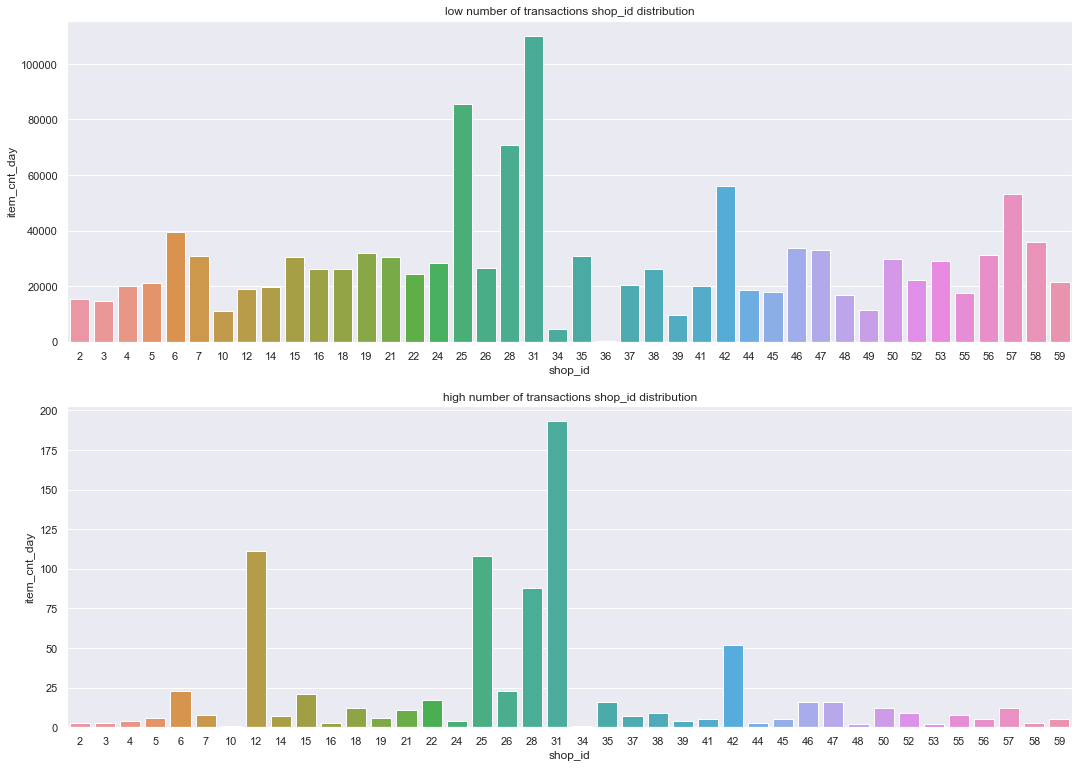

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(18,13))
sns.barplot(x="shop_id", y="item_cnt_day", data=lowsales_pivot, ax = axs[0])
sns.barplot(x="shop_id", y="item_cnt_day", data=highsales_pivot, ax = axs[1])
axs[0].title.set_text('low number of transactions shop_id distribution')
axs[1].title.set_text('high number of transactions shop_id distribution')
plt.show()

there is no clear distinction here, just some stores with high sales

<b> Time outlier checking

In [46]:
dfplot = train_merge.pivot_table(index = ['SaleDate','shop_id'], values = 'item_cnt_day', aggfunc = 'count').reset_index().sort_values('item_cnt_day')

Text(0.5, 1.0, 'Number of transaction distribution by shopId across the time')

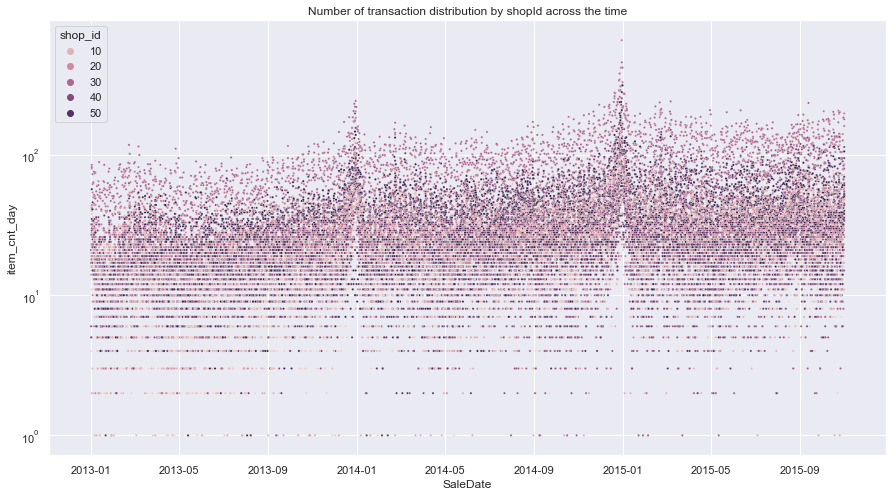

In [47]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(data=dfplot, x="SaleDate", y="item_cnt_day", hue="shop_id", s = 5)
plt.yscale('log')
plt.title('Number of transaction distribution by shopId across the time')

In [48]:
dfplot = train_merge.pivot_table(index = ['SaleDate','shop_id'], values = 'item_id', aggfunc = lambda x: len(x.unique()) ).reset_index()

Text(0.5, 1.0, 'unique items saled by time and shop')

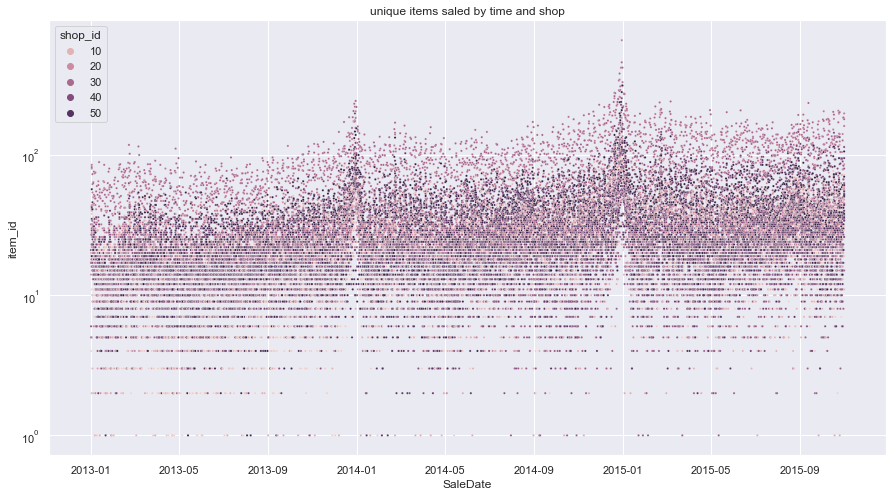

In [49]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(data=dfplot, x="SaleDate", y="item_id", hue="shop_id", s = 5)
plt.yscale('log')
plt.title('unique items saled by time and shop')

<b> Some impressions about the outliers

* from the previous section of the EDA
    + there are shops with high number number of transactions - ideal to group or encode by volume of transactions
    + there are items with high number number of transactions - ideal to group or encode by volume of transactions
* from the currect section of the EDA
    + seasonality exists 
    + a trend exists

#### Analysis of returns an actual sales

In [50]:
dfplot = train_merge.assign(TransactionType = np.where(train_merge.item_cnt_day <= 0, 'SaleBack', 'Sale'))\
    .pivot_table(index = ['SaleDate','shop_id','TransactionType'], values = 'item_cnt_day', aggfunc = 'sum')\
    .reset_index().sort_values('item_cnt_day')

dfplot['item_cnt_day'] = abs(dfplot['item_cnt_day'])

C:\Users\Miguel\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


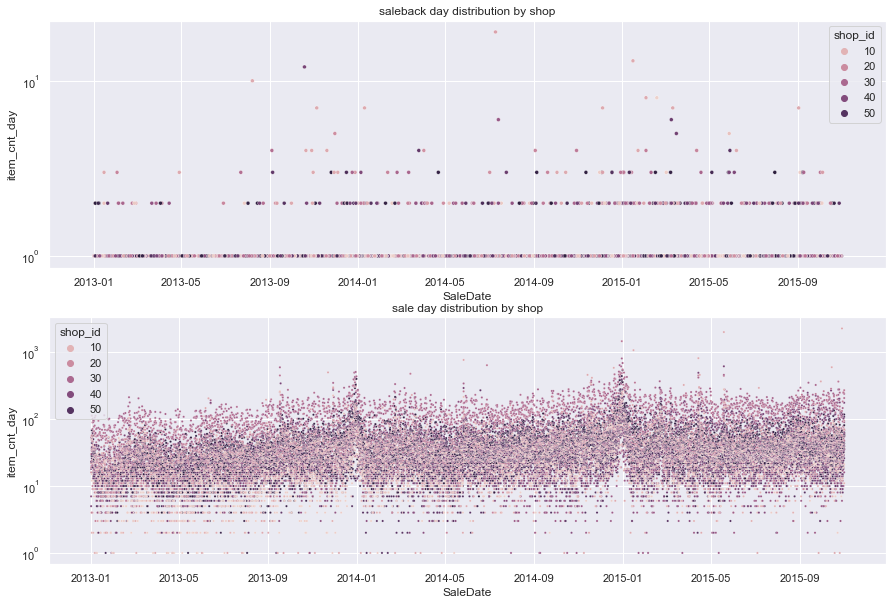

In [51]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(15,10))
ax = sns.scatterplot(ax = axs[0] , data = dfplot[dfplot.TransactionType == 'SaleBack'] , x="SaleDate", y="item_cnt_day", hue = 'shop_id', s = 15)
ax = sns.scatterplot(ax = axs[1] , data = dfplot[dfplot.TransactionType == 'Sale'], x="SaleDate", y="item_cnt_day", hue = 'shop_id', s = 5)
axs[0].title.set_text('saleback day distribution by shop')
axs[1].title.set_text('sale day distribution by shop')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
fig.show()

insights
* normal sales have a defined pattern
* back sales do not have a clear trend

<b> test aggregation by month then split sales and sales back

In [52]:
train_merge.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_name,ID,SaleDate
0,02.01.2013,0,59,22154,999.0000,1.0000,ЯВЛЕНИЕ 2012 (BD),Кино - Blu-Ray,150983,2013-01-02
1,03.01.2013,0,25,2574,399.0000,2.0000,DEL REY LANA Born To Die The Paradise Editio...,Музыка - CD локального производства,56520,2013-01-03


In [53]:
def convert_bronze(data):
    data_result = data.assign(TransactionType = np.where(data.item_cnt_day <= 0, 'SaleBack', 'Sale'))
    data_result['SaleDateMY'] = data_result['SaleDate'].dt.to_period('M').dt.to_timestamp()
    result = data_result.pivot_table(index = ['SaleDateMY', 'date_block_num', 'shop_id', 'item_id', 'TransactionType'], values = 'item_cnt_day',aggfunc = 'sum')
    result = result.reset_index()
    return result

In [54]:
pivoted_train = convert_bronze(train_merge)

In [56]:
pivotplot = pivoted_train.pivot_table(index = ['SaleDateMY', 'shop_id', 'TransactionType'], values = 'item_cnt_day', aggfunc = 'sum').reset_index()
pivotplot['item_cnt_day'] = abs(pivotplot['item_cnt_day'])

C:\Users\Miguel\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


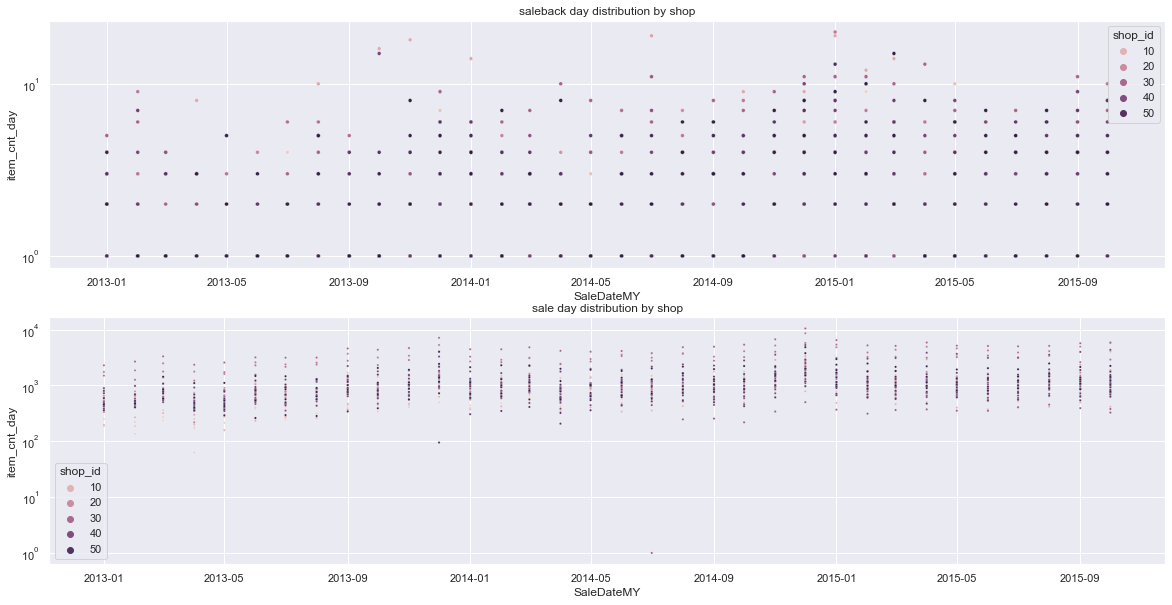

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
ax = sns.scatterplot(ax = axs[0] , data = pivotplot[pivotplot.TransactionType == 'SaleBack'] , x="SaleDateMY", y="item_cnt_day", hue = 'shop_id', s = 15)
ax = sns.scatterplot(ax = axs[1] , data = pivotplot[pivotplot.TransactionType == 'Sale'], x="SaleDateMY", y="item_cnt_day", hue = 'shop_id', s = 5)
axs[0].title.set_text('saleback day distribution by shop')
axs[1].title.set_text('sale day distribution by shop')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
fig.show()

In [58]:
pivotplot = pivoted_train.pivot_table(index = ['SaleDateMY', 'shop_id'], values = 'item_id', aggfunc = lambda x: len(x.unique()) ).reset_index()

Text(0.5, 1.0, 'unique number of items saled by shop')

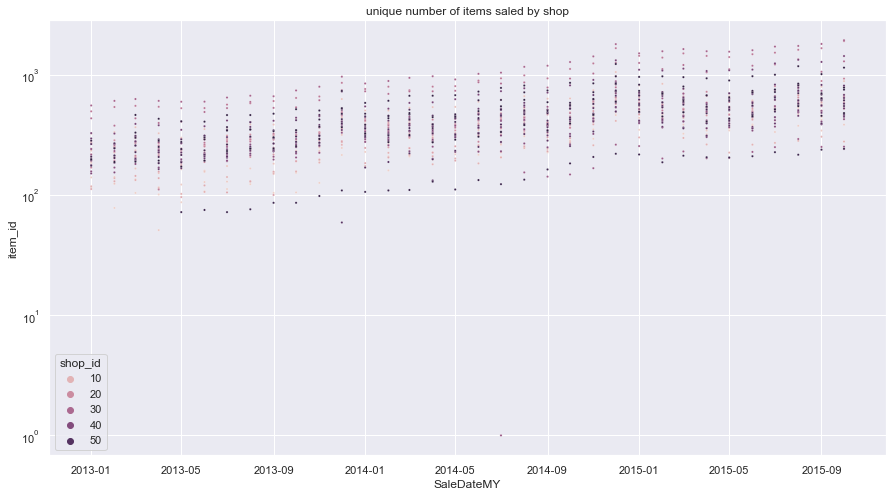

In [59]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot( data = pivotplot, x="SaleDateMY", y="item_id", hue = 'shop_id', s = 5)
plt.yscale('log')
plt.title('unique number of items saled by shop')

#### Inspection of incomplete individual time series

In [60]:
pivoted_train.head()

,SaleDateMY,date_block_num,shop_id,item_id,TransactionType,item_cnt_day
0,2013-01-01,0,2,33,Sale,1.0000
1,2013-01-01,0,2,482,Sale,1.0000
2,2013-01-01,0,2,491,Sale,1.0000
3,2013-01-01,0,2,839,Sale,1.0000
4,2013-01-01,0,2,1007,Sale,3.0000


In [61]:
dfexe = pivoted_train.pivot_table(index = ['shop_id','item_id'], columns = 'TransactionType', values = 'SaleDateMY', aggfunc = lambda x: len(x.unique())  ).reset_index()

In [62]:
dfexe.sort_values('SaleBack', ascending = False)

TransactionType,shop_id,item_id,Sale,SaleBack
17850,12,3732,21.0000,5.0000
87029,48,5816,16.0000,4.0000
2274,3,3556,21.0000,4.0000
17852,12,3734,17.0000,4.0000
103325,57,4249,30.0000,4.0000
...,...,...,...,...
111399,59,22145,2.0000,nan
111400,59,22154,1.0000,nan
111401,59,22162,5.0000,nan
111402,59,22164,4.0000,nan


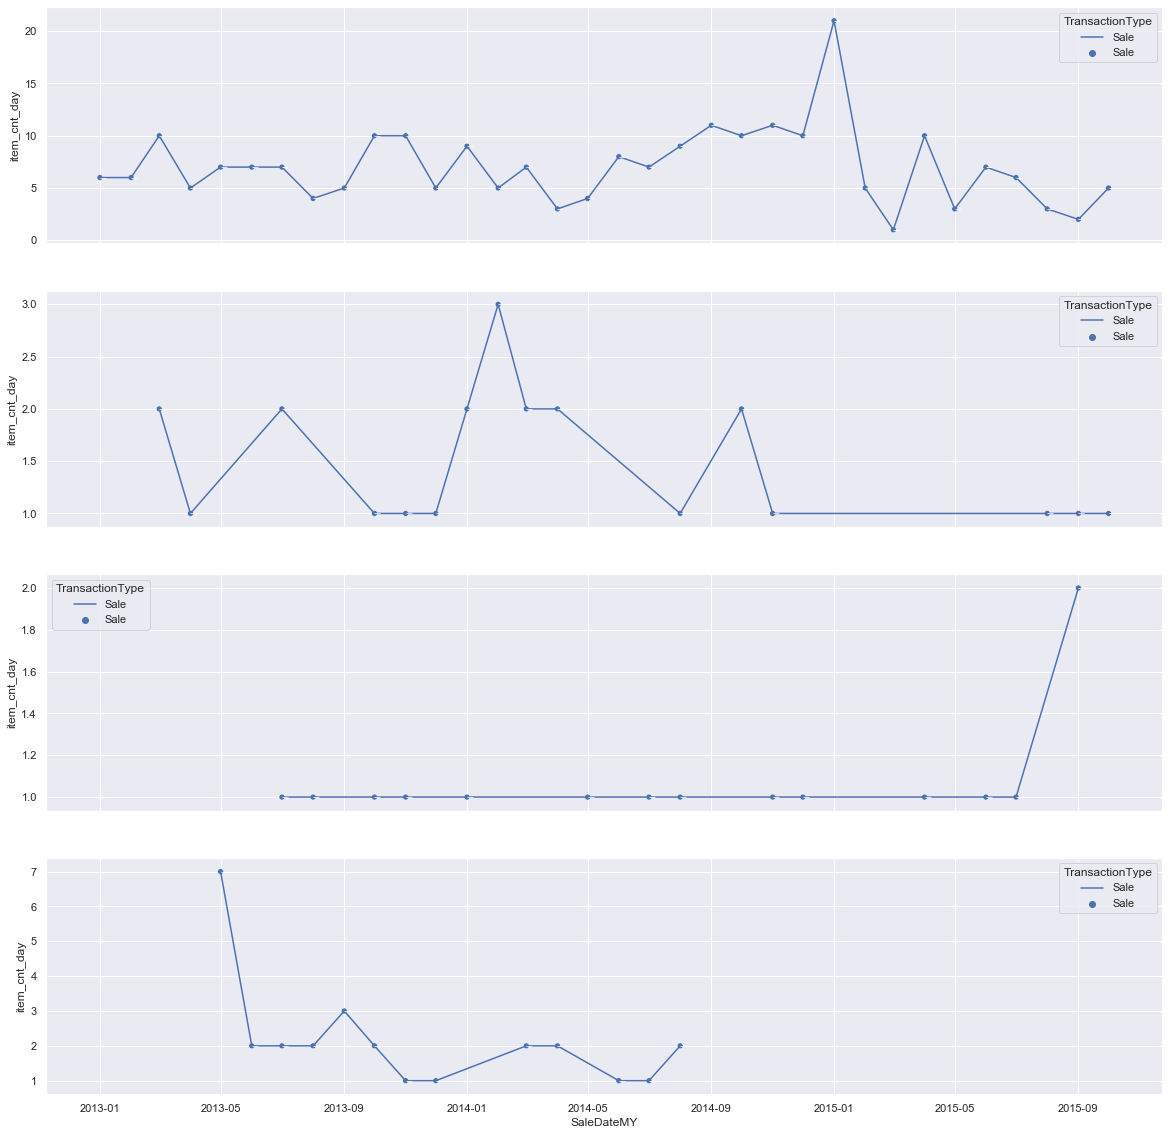

In [63]:
fig, axs = plt.subplots(nrows=4, ncols=1,figsize=(20,20), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = pivoted_train[(pivoted_train.shop_id == 42) & (pivoted_train.item_id == 7856)] , x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', marker = True, )
ax = sns.lineplot(ax = axs[1] , data = pivoted_train[(pivoted_train.shop_id == 31) & (pivoted_train.item_id == 18016)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', marker = True, )
ax = sns.lineplot(ax = axs[2] , data = pivoted_train[(pivoted_train.shop_id == 59) & (pivoted_train.item_id == 12472)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', marker = True, )
ax = sns.lineplot(ax = axs[3] , data = pivoted_train[(pivoted_train.shop_id == 45) & (pivoted_train.item_id == 8686)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', marker = True, )

ax = sns.scatterplot(ax = axs[0] , data = pivoted_train[(pivoted_train.shop_id == 42) & (pivoted_train.item_id == 7856)] , x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', s = 35 )
ax = sns.scatterplot(ax = axs[1] , data = pivoted_train[(pivoted_train.shop_id == 31) & (pivoted_train.item_id == 18016)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', s = 35 )
ax = sns.scatterplot(ax = axs[2] , data = pivoted_train[(pivoted_train.shop_id == 59) & (pivoted_train.item_id == 12472)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', s = 35 )
ax = sns.scatterplot(ax = axs[3] , data = pivoted_train[(pivoted_train.shop_id == 45) & (pivoted_train.item_id == 8686)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', s = 35 )

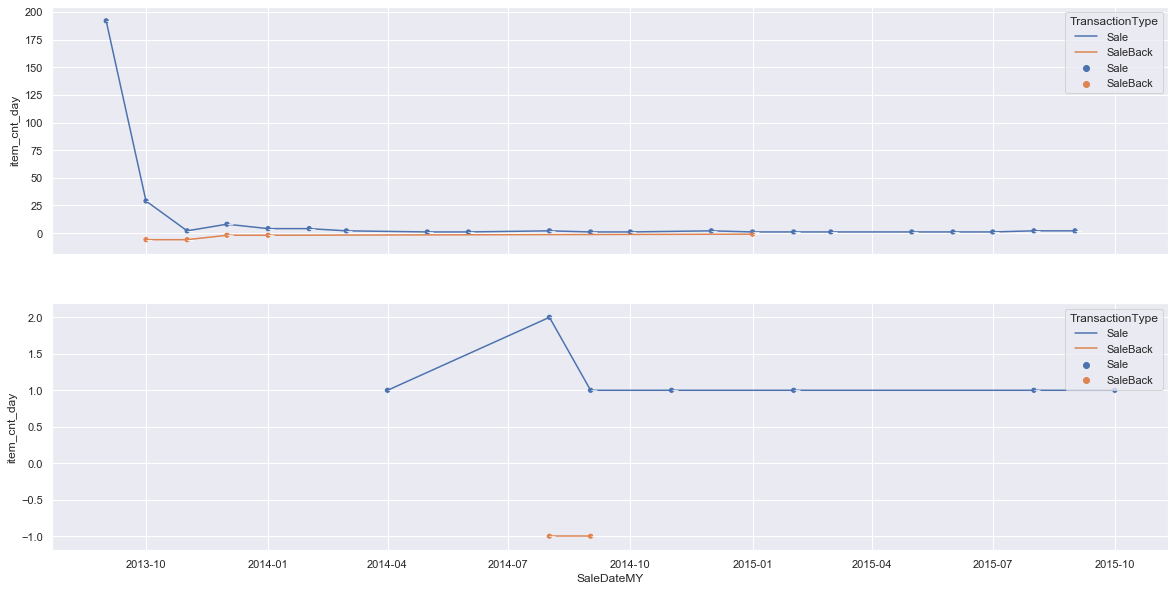

In [66]:
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(20,10), sharex=True)
ax = sns.lineplot(ax = axs[0] , data = pivoted_train[(pivoted_train.shop_id == 12) & (pivoted_train.item_id == 3732)] , x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', marker = True, )
ax = sns.lineplot(ax = axs[1] , data = pivoted_train[(pivoted_train.shop_id == 48) & (pivoted_train.item_id == 16461)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', marker = True, )

ax = sns.scatterplot(ax = axs[0] , data = pivoted_train[(pivoted_train.shop_id == 12) & (pivoted_train.item_id == 3732)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', s = 35 )
ax = sns.scatterplot(ax = axs[1] , data = pivoted_train[(pivoted_train.shop_id == 48) & (pivoted_train.item_id ==16461)], x="SaleDateMY", y="item_cnt_day", hue = 'TransactionType', s = 35 )

(734869.0, 735872.0)

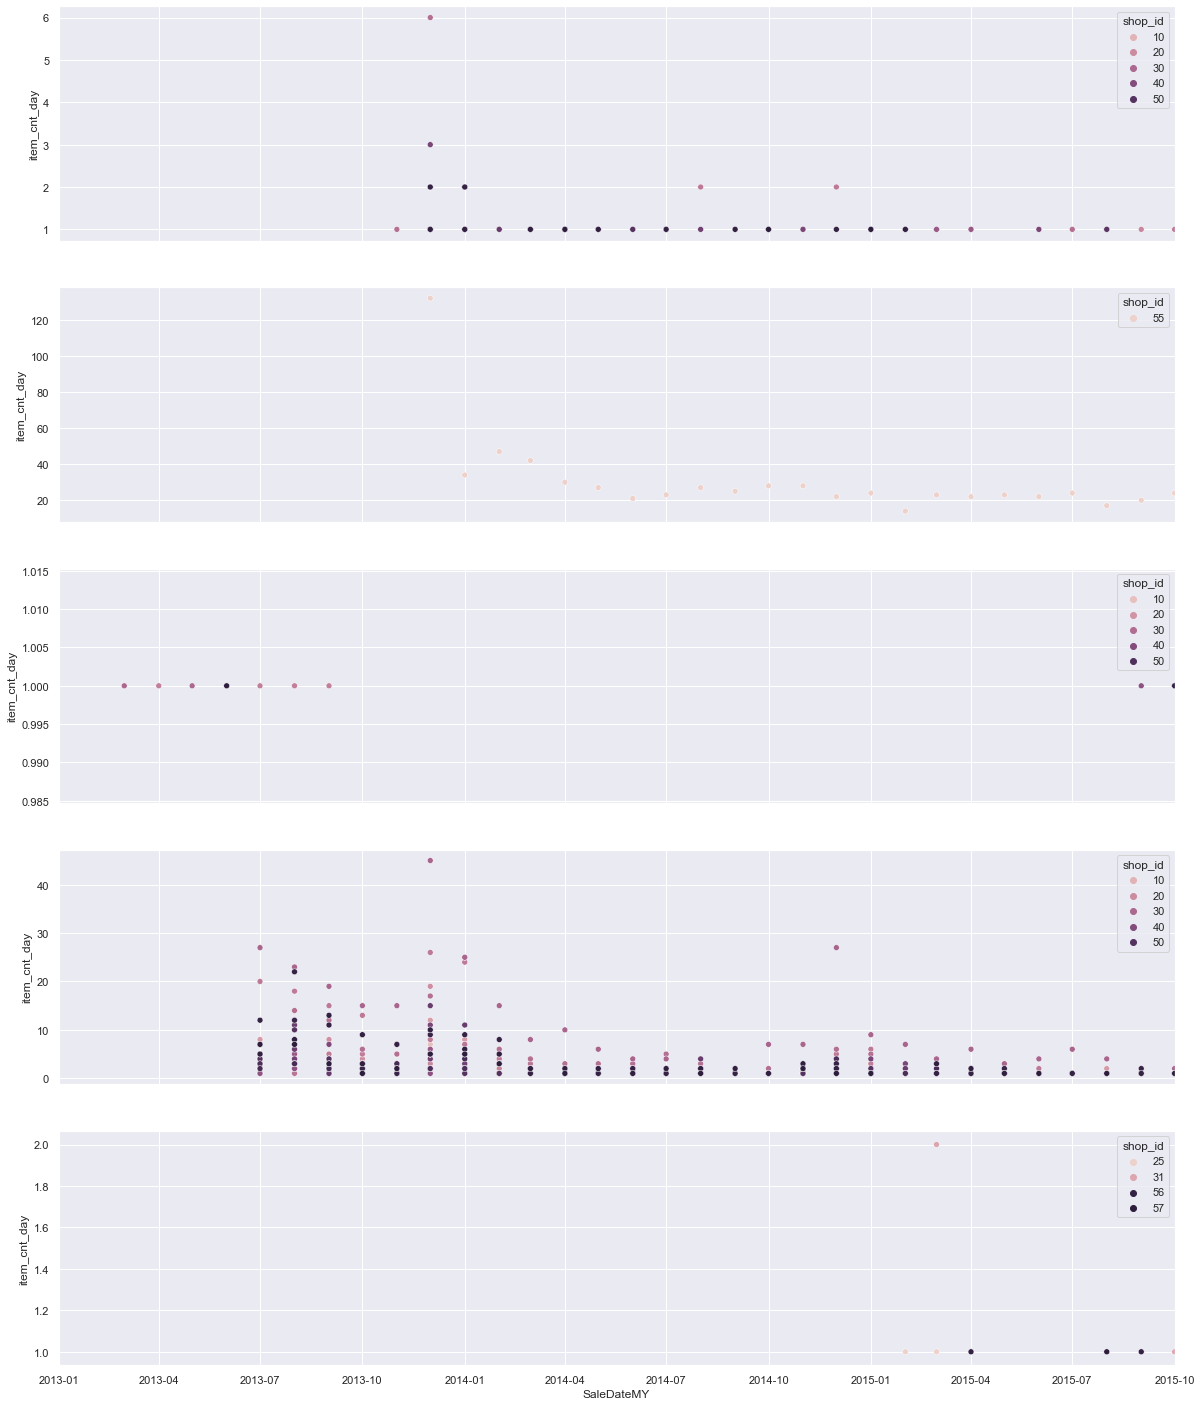

In [80]:
fig, axs = plt.subplots(nrows=5, ncols=1,figsize=(20,25), sharex=True)
ax = sns.scatterplot(ax = axs[0] , data = pivoted_train[pivoted_train.item_id == np.random.choice(np.array(pivoted_train.item_id.unique()),1)[0]] , x="SaleDateMY", y="item_cnt_day", hue = 'shop_id',s = 35)
ax = sns.scatterplot(ax = axs[1] , data = pivoted_train[pivoted_train.item_id == np.random.choice(np.array(pivoted_train.item_id.unique()),1)[0]], x="SaleDateMY", y="item_cnt_day", hue = 'shop_id',s = 35)
ax = sns.scatterplot(ax = axs[2] , data = pivoted_train[pivoted_train.item_id == np.random.choice(np.array(pivoted_train.item_id.unique()),1)[0]], x="SaleDateMY", y="item_cnt_day", hue = 'shop_id',s = 35)
ax = sns.scatterplot(ax = axs[3] , data = pivoted_train[pivoted_train.item_id == np.random.choice(np.array(pivoted_train.item_id.unique()),1)[0]], x="SaleDateMY", y="item_cnt_day", hue = 'shop_id',s = 35)
ax = sns.scatterplot(ax = axs[4] , data = pivoted_train[pivoted_train.item_id == np.random.choice(np.array(pivoted_train.item_id.unique()),1)[0]], x="SaleDateMY", y="item_cnt_day", hue = 'shop_id',s = 35)
plt.xlim(pivoted_train.SaleDateMY.min(), pivoted_train.SaleDateMY.max())

In [135]:
dfexe = pivoted_train.pivot_table(index = ['shop_id','item_id','SaleDateMY'], values = 'item_cnt_day', aggfunc = 'sum'  ).reset_index()
dfexe = dfexe.assign(shopitem = dfexe.shop_id.astype('str') +'-'+ dfexe.item_id.astype('str') )
dfexe['GlobalTimeObs'] = dfexe.groupby('shopitem')['SaleDateMY'].transform('count')
dfexe['indexShopItem'] = dfexe['shopitem'].rank(method='dense')

Text(0.5, 1.0, 'unique')

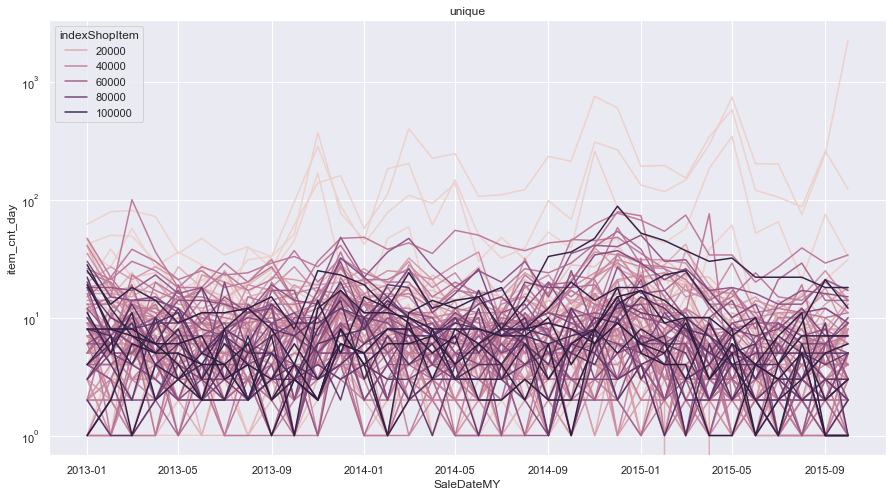

In [138]:
fig = plt.figure(figsize=(15,8))
sns.lineplot( data = dfexe[dfexe.GlobalTimeObs >= 34], x="SaleDateMY", y="item_cnt_day", hue = 'indexShopItem')
plt.yscale('log')
plt.title('unique')

Text(0.5, 1.0, 'unique')

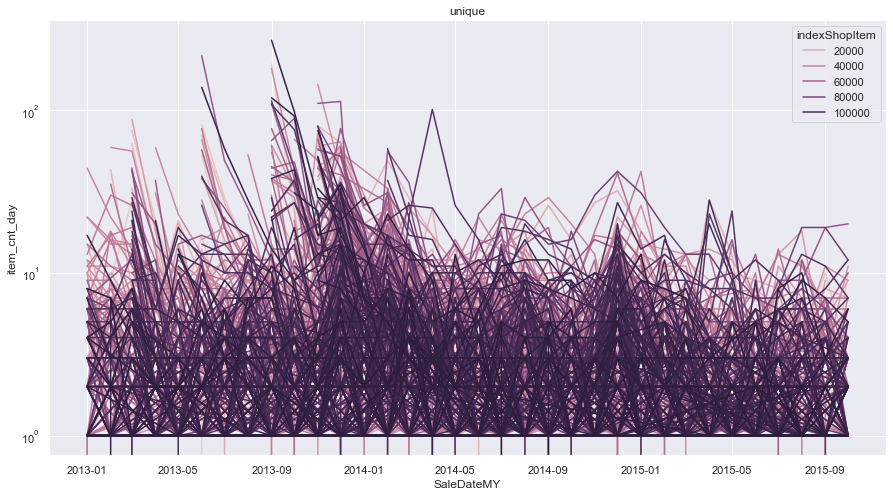

In [142]:
fig = plt.figure(figsize=(15,8))
sns.lineplot( data = dfexe[(dfexe.GlobalTimeObs >= 21) & (dfexe.GlobalTimeObs <= 22)], x="SaleDateMY", y="item_cnt_day", hue = 'indexShopItem')
plt.yscale('log')
plt.title('unique')

<b> completion timeseries

In [93]:
dfexe = pivoted_train.pivot_table(index = ['shop_id','item_id'], values = 'SaleDateMY', aggfunc = lambda x: len(x.unique())  ).reset_index().rename(columns = {'SaleDateMY':'Sale'})

In [97]:
dfplot_itemshop = dfexe.assign(shopitem = dfexe.shop_id.astype('str') +'-'+ dfexe.item_id.astype('str') )\
    .pivot_table(index = 'Sale', values = 'shopitem', aggfunc = lambda x: len(x.unique()) )\
    .reset_index()\
    .sort_values('Sale', ascending = False)

[Text(0, 0.5, 'count of shop and item ids'),
 Text(0.5, 0, 'number of observations'),
 Text(0.5, 1.0, 'completion of time series per shop and item')]

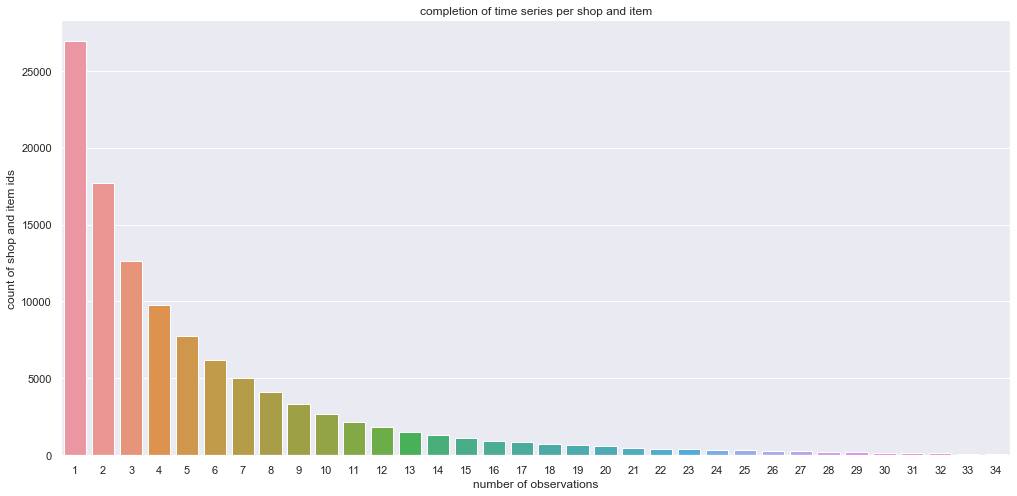

In [98]:
fig = plt.figure(figsize=(17,8))
ax = sns.barplot(x="Sale", y="shopitem", data=dfplot_itemshop)
ax.set(xlabel='number of observations', ylabel='count of shop and item ids', title='completion of time series per shop and item')

In [101]:
dfexe = pivoted_train[pivoted_train.SaleDateMY >= datetime.datetime(2014, 10, 1)]\
    .pivot_table(index = ['shop_id','item_id'], values = 'SaleDateMY', aggfunc = lambda x: len(x.unique())  )\
    .reset_index()\
    .rename(columns = {'SaleDateMY':'Sale'})

In [102]:
dfplot_itemshop = dfexe.assign(shopitem = dfexe.shop_id.astype('str') +'-'+ dfexe.item_id.astype('str') )\
    .pivot_table(index = 'Sale', values = 'shopitem', aggfunc = lambda x: len(x.unique()) )\
    .reset_index()\
    .sort_values('Sale', ascending = False)

[Text(0, 0.5, 'count of shop and item ids'),
 Text(0.5, 0, 'number of observations'),
 Text(0.5, 1.0, 'completion of time series per shop and item in the last year')]

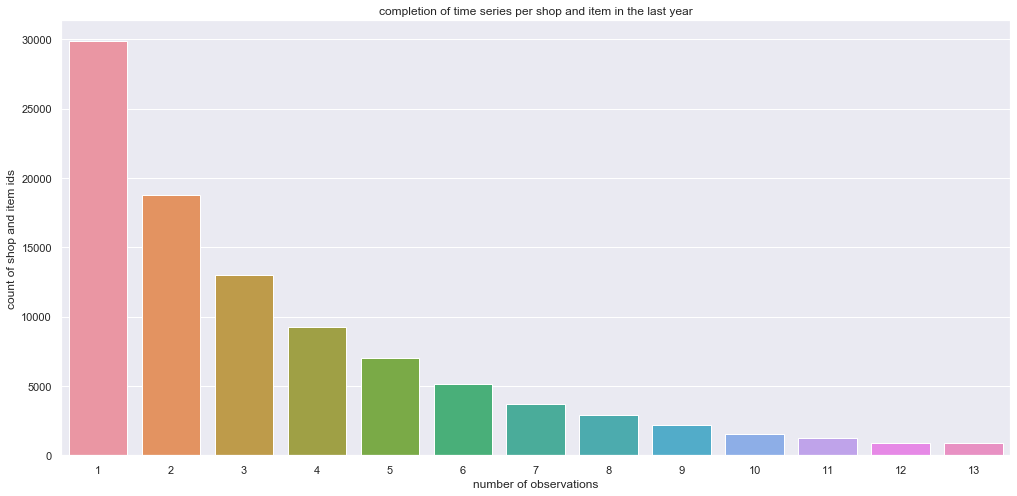

In [104]:
fig = plt.figure(figsize=(17,8))
ax = sns.barplot(x="Sale", y="shopitem", data=dfplot_itemshop)
ax.set(xlabel='number of observations', ylabel='count of shop and item ids', title='completion of time series per shop and item in the last year')

In [144]:
dfexe = pivoted_train[pivoted_train.SaleDateMY >= datetime.datetime(2015, 5, 1)]\
    .pivot_table(index = ['shop_id','item_id'], values = 'SaleDateMY', aggfunc = lambda x: len(x.unique())  )\
    .reset_index()\
    .rename(columns = {'SaleDateMY':'Sale'})

In [145]:
dfplot_itemshop = dfexe.assign(shopitem = dfexe.shop_id.astype('str') +'-'+ dfexe.item_id.astype('str') )\
    .pivot_table(index = 'Sale', values = 'shopitem', aggfunc = lambda x: len(x.unique()) )\
    .reset_index()\
    .sort_values('Sale', ascending = False)

[Text(0, 0.5, 'count of shop and item ids'),
 Text(0.5, 0, 'number of observations'),
 Text(0.5, 1.0, 'completion of time series per shop and item in the last year')]

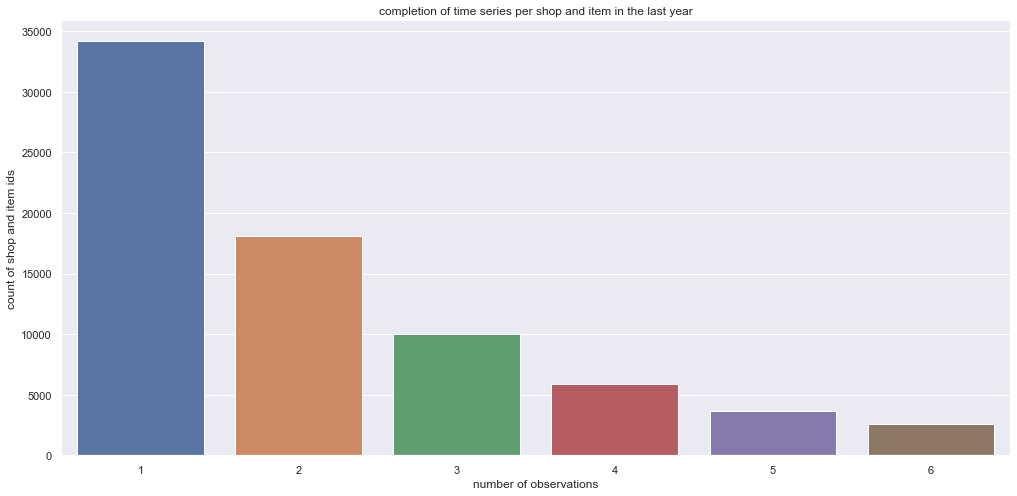

In [146]:
fig = plt.figure(figsize=(17,8))
ax = sns.barplot(x="Sale", y="shopitem", data=dfplot_itemshop)
ax.set(xlabel='number of observations', ylabel='count of shop and item ids', title='completion of time series per shop and item in the last year')

<b> some insights

* there are full time series, almost full and deprecated time series
* for the while group the type of transaction
* if empty use a median low value
* same item id no compact distribution
* combinations of items and shops - some full a big proportion is incomplete
* time series features
  + take previous lags
  + take one or two year back lags
  + shopid + itemid encoding + exotic variations
  + how full is a time series
  + if there is previous data
  + if insuficient data then 0 
* huge density to individual time series to forecast
* check last year completion and even semester completion
* cluster using last transaction and even some lags with averages

for almost completed time series, it is possible to do something, for the rest mmmmmm

<b> procceded with feature enginering ML modeling